## Notebook Overview
- Load stored prediction archives for baseline, balanced, and random experiments.
- Compute per-race mean differences across reruns and assemble summary tables.
- Calculate effect sizes for overall and per-race contrasts across experimental setups.
- Export derived CSVs to support downstream statistical analyses.


In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
name = 'rand_bal'
races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']

def load_data(name):

    loaded_masks = {}

    with h5py.File(f'experiments_data/{name}_masks.h5', 'r') as hdf:
        for race in hdf.keys():  # Iterate over the keys (which are the race names)
            loaded_masks[race] = np.array(hdf[race])  # Load each dataset as a NumPy array

    masks = loaded_masks

    data = np.load(f'experiments_data/{name}_predictions_50.npz')

    probs_no_race = data['probs_no_race']
    probs_with_race = data['probs_with_race']
    
    return probs_no_race, probs_with_race, masks

Creating a mean dataframe across all reruns:

In [3]:
probs_no_race, probs_with_race, masks = load_data(name)

num_predictions = probs_no_race.shape[1]

race_labels = np.empty(probs_no_race.shape[1], dtype=object)

for race in masks:
  race_labels[masks[race]] = race
  
diffs = probs_with_race - probs_no_race
mean_diffs = np.mean(diffs, axis=0)

mean_diff_df = pd.DataFrame({
    "Difference": mean_diffs,
    "Race": race_labels,
    "Patient Number": np.arange(1, num_predictions + 1)
})

mean_diff_df.to_csv(f'experiments_data/{name}_mean_diffs.csv', index=False)

In [4]:
name = 'baseline'
probs_no_race, probs_with_race, masks = load_data(name)
labels_test = np.load('experiments_data/data_variables.npz')['Y_test']

num_predictions = probs_no_race.shape[1]

race_labels = np.empty(probs_no_race.shape[1], dtype=object)

for race in masks:
  race_labels[masks[race]] = race
  
probs_no_race = probs_no_race.mean(axis=0)
probs_with_race = probs_with_race.mean(axis=0)

mean_pred_df = pd.DataFrame({
    "Prediction:": np.concatenate([probs_no_race, probs_with_race]),
    "Label": np.concatenate([labels_test, labels_test]),
    "Rater": ["No_Race"] * probs_no_race.size + ["With_Race"] * probs_with_race.size,
    "Race": np.tile(race_labels, 2),
    "Patient Number": np.tile(np.arange(0, num_predictions), 2)
})

mean_pred_df.to_csv(f'experiments_data/{name}_mean_preds.csv', index=False)

Creating a mean dataframe for every race of every rerun:

In [5]:
### NOT WORKING YET

probs_no_race, probs_with_race, masks = load_data(name)
num_reruns = probs_no_race.shape[0]

races = list(masks.keys())

means = np.zeros((2*num_reruns, len(races)))

for i in range(num_reruns):
    for j, race in enumerate(races):
        means[2*i, j] = probs_with_race[i, masks[race]].mean()
        means[2*i+1, j] = probs_no_race[i, masks[race]].mean()
    
race_labels = np.repeat(np.tile(races, probs_no_race.shape[0]), 2)
rerun = np.repeat(np.arange(1, probs_no_race.shape[0] + 1), 2*len(races))
model_type = np.tile(['With_Race', 'No_Race'], num_reruns*len(races))

mean_per_run = pd.DataFrame({
    "Rerun": rerun,
    "Model": model_type,
    "Race": race_labels,
    "Mean": means.flatten()
})


In [6]:
mean_per_run

,Rerun,Model,Race,Mean
0,1,With_Race,ASIAN,0.321009
1,1,No_Race,ASIAN,0.279205
2,1,With_Race,BLACK,0.230058
3,1,No_Race,BLACK,0.301852
4,1,With_Race,HISPANIC,0.446732
...,...,...,...,...
495,50,No_Race,HISPANIC,0.313527
496,50,With_Race,OTHER,0.308713
497,50,No_Race,OTHER,0.279363
498,50,With_Race,WHITE,0.308775


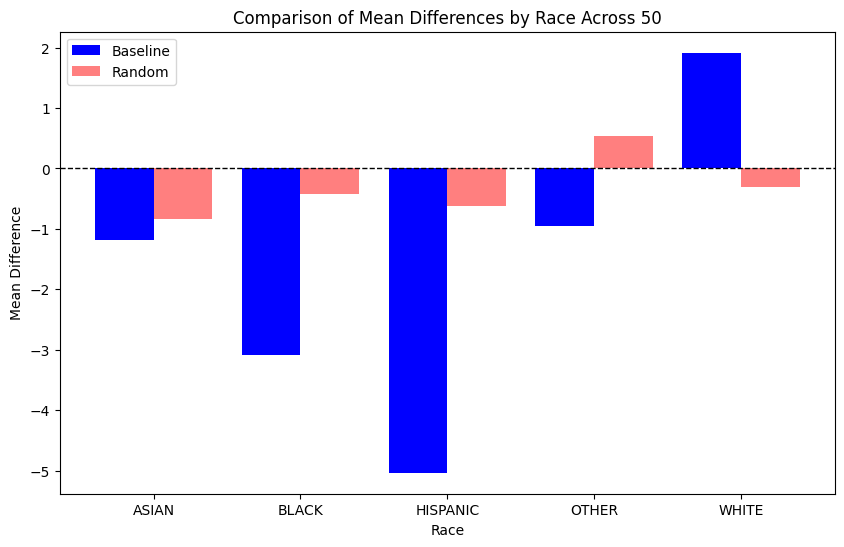

In [7]:
def compute_race_diffs(name):
    races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']
    loaded_masks = {}

    with h5py.File(f'experiments_data/{name}_masks.h5', 'r') as hdf:
        for race in hdf.keys():
            loaded_masks[race] = np.array(hdf[race])

    masks = loaded_masks
    data = np.load(f'experiments_data/{name}_predictions_50.npz')

    probs_no_race = data['probs_no_race']
    probs_with_race = data['probs_with_race']

    mean_across_no_race = probs_no_race.mean(axis=0)
    mean_across_with_race = probs_with_race.mean(axis=0)

    race_diffs = []
    for race in races:
        vals_no_race = mean_across_no_race[masks[race]]
        vals_with_race = mean_across_with_race[masks[race]]
        diff = (vals_with_race - vals_no_race).mean()
        race_diffs.append(diff)

    return races, race_diffs

# Compute differences for both experiments
races, race_diffs_random = compute_race_diffs('random')
_, race_diffs_baseline = compute_race_diffs('baseline')
_, race_diffs_balanced = compute_race_diffs('balanced')
race_diffs_balanced = np.array(race_diffs_balanced)*100

race_diffs_random = np.array(race_diffs_random)*100
race_diffs_baseline = np.array(race_diffs_baseline)*100

# Plot both on the same axes with side-by-side bars
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4  # Set a bar width
x = np.arange(len(races))  # Bar positions

# Baseline in blue (left side of each group)
ax.bar(x - bar_width / 2, race_diffs_baseline, width=bar_width, color='blue', alpha=1.0, label="Baseline")

# Random in grey (right side of each group)
ax.bar(x + bar_width / 2, race_diffs_random, width=bar_width, color='red', alpha=0.5, label="Random")

# Add horizontal line at y=0
ax.axhline(0, color='black', linewidth=1, linestyle='--')

ax.set_xticks(x)
ax.set_xticklabels(races)
ax.set_xlabel("Race")
ax.set_ylabel("Mean Difference")
ax.set_title("Comparison of Mean Differences by Race Across 50")
ax.legend()

plt.show()



In [8]:
print(race_diffs_baseline)
print(race_diffs_random)
print(race_diffs_balanced)

[-1.1770711 -3.0947833 -5.036782  -0.9587596  1.9150808]
[-0.83925194 -0.42944717 -0.62293166  0.54349554 -0.31452134]
[ 0.49232566 -1.4892817  -3.0062659   0.23114705  3.1966834 ]


# Effect Size Calculations

In [9]:
probs_no_race_baseline, probs_with_race_baseline, masks_baseline = load_data('baseline')
probs_no_race_random, probs_with_race_random, masks_random = load_data('random')
probs_no_race_balanced, probs_with_race_balanced, masks_balanced = load_data('balanced')

def compute_effect_size(values1, values2):
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)
    variance1 = np.var(values1)
    variance2 = np.var(values2)
    n1 = len(values1)
    n2 = len(values2)
    pooled_variance = ((n1 - 1) * variance1 + (n2 - 1) * variance2) / (n1 + n2 - 2)
    effect_size = (mean1 - mean2) / np.sqrt(pooled_variance)
    return effect_size

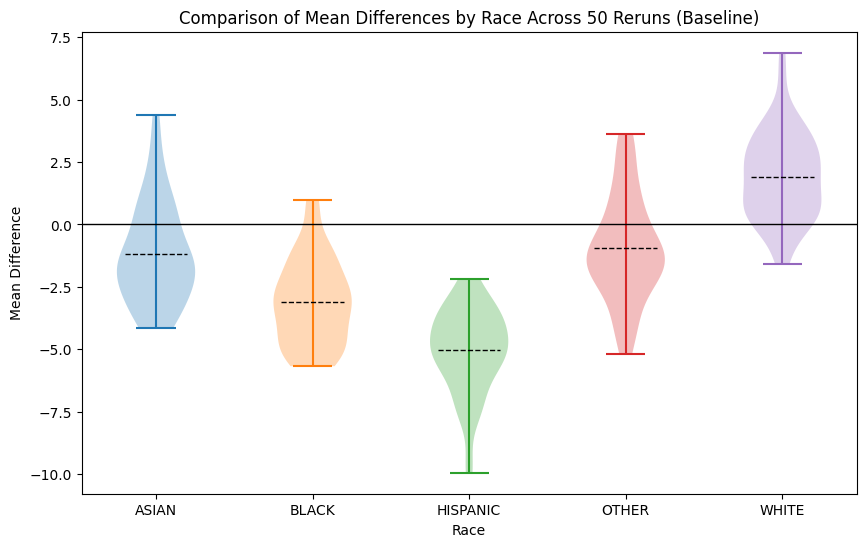

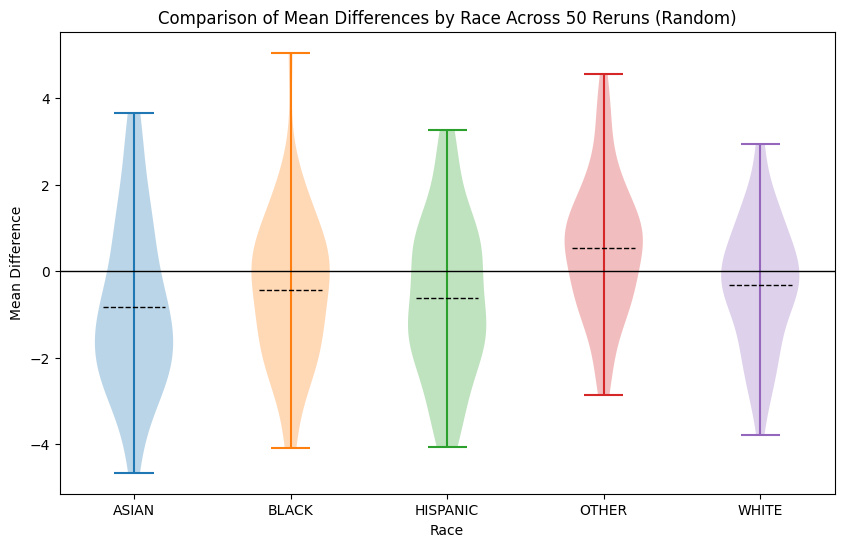

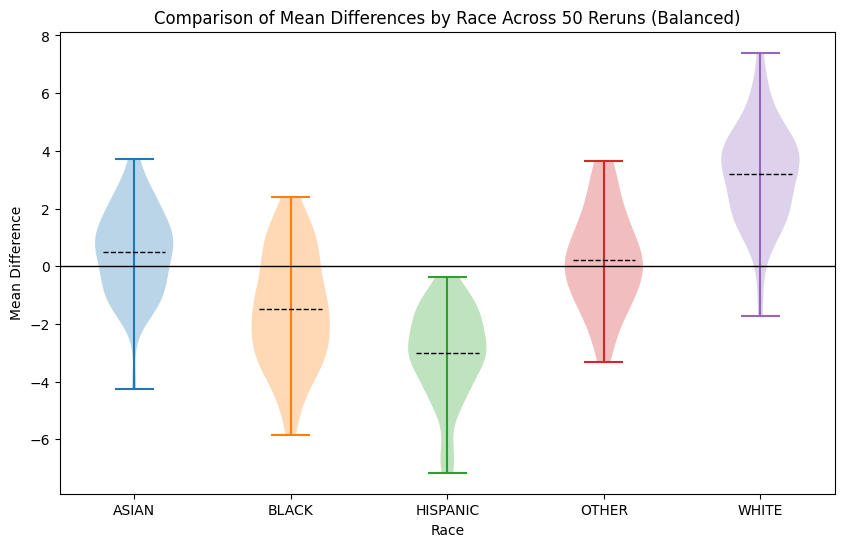

In [10]:
def get_race_means(probs_no_race, probs_with_race, masks, races):
    dict_race_means = {race: None for race in races}
    for race in races:
        masked_diffs = (probs_with_race[:, masks[race]] - probs_no_race[:, masks[race]])
        mean_across_rows = masked_diffs.mean(axis=1)
        dict_race_means[race] = mean_across_rows*100
    return dict_race_means

def violin_plot_means(dict_race_means, races, title = 'Violin Plot'):
    fig, ax = plt.subplots(figsize=(10, 6))
    for race in races:
        ax.violinplot(dict_race_means[race], positions=[races.index(race)], widths=0.5)
    # Add horizontal line at y=0
    ax.axhline(0, color='black', linewidth=1)
    # Add dotted line for the mean of each race
    for race in races:
        mean = np.mean(dict_race_means[race])
        ax.plot([races.index(race) - 0.2, races.index(race) + 0.2], [mean, mean], color='black', linestyle='--', linewidth=1)
    ax.set_xticks(range(len(races)))
    ax.set_xticklabels(races)
    ax.set_xlabel("Race")
    ax.set_ylabel("Mean Difference")
    ax.set_title(title)
    plt.show()
    
    
races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']
dict_race_means = get_race_means(probs_no_race_baseline, probs_with_race_baseline, masks_baseline, races)
violin_plot_means(dict_race_means, races, title='Comparison of Mean Differences by Race Across 50 Reruns (Baseline)')

dict_race_means = get_race_means(probs_no_race_random, probs_with_race_random, masks_random, races)
violin_plot_means(dict_race_means, races, title='Comparison of Mean Differences by Race Across 50 Reruns (Random)')

dict_race_means = get_race_means(probs_no_race_balanced, probs_with_race_balanced, masks_balanced, races)
violin_plot_means(dict_race_means, races, title='Comparison of Mean Differences by Race Across 50 Reruns (Balanced)')

Effect size of total datasets:

In [11]:
print('Baseline')
baseline_es = compute_effect_size(np.mean(probs_with_race_baseline, axis=0), np.mean(probs_no_race_baseline, axis=0))
print(f'Effect Size: {baseline_es}')

print('Random')
random_es = compute_effect_size(np.mean(probs_with_race_random, axis=0), np.mean(probs_no_race_random, axis=0))
print(f'Effect Size: {random_es}')

print('Balanced')
balanced_es = compute_effect_size(np.mean(probs_with_race_balanced, axis=0), np.mean(probs_no_race_balanced, axis=0))
print(f'Effect Size: {balanced_es}')

Baseline
Effect Size: -0.00303054042160511
Random
Effect Size: -0.010473893955349922
Balanced
Effect Size: -0.0036623443011194468


Effect size between models trained on race vs. without for each data type

In [12]:
def baseline_effect_size(probs_no_race, probs_with_race, masks):
    print('\n','='*80)
    races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']
    mean_no_race = np.mean(probs_no_race, axis=0)
    mean_with_race = np.mean(probs_with_race, axis=0)
    for race in races:
        print(f'Race: {race}')
        effect_size = compute_effect_size(mean_no_race[masks[race]], mean_with_race[masks[race]])
        print(f'Effect Size: {effect_size}')
    print('='*80, '\n')
    
print('Baseline')
baseline_effect_size(probs_with_race_baseline, probs_no_race_baseline, masks_baseline)

print('Random')
baseline_effect_size(probs_with_race_random, probs_no_race_random, masks_random)

print('Balanced')
baseline_effect_size(probs_with_race_balanced, probs_no_race_balanced, masks_balanced)

Baseline

Race: ASIAN
Effect Size: -0.0379735566675663
Race: BLACK
Effect Size: -0.1090298667550087
Race: HISPANIC
Effect Size: -0.19032154977321625
Race: OTHER
Effect Size: -0.030898043885827065
Race: WHITE
Effect Size: 0.05798443406820297

Random

Race: ASIAN
Effect Size: -0.026505516842007637
Race: BLACK
Effect Size: -0.013446028344333172
Race: HISPANIC
Effect Size: -0.019609497860074043
Race: OTHER
Effect Size: 0.01684357412159443
Race: WHITE
Effect Size: -0.009803530760109425

Balanced

Race: ASIAN
Effect Size: 0.015352648682892323
Race: BLACK
Effect Size: -0.0516265444457531
Race: HISPANIC
Effect Size: -0.11132320016622543
Race: OTHER
Effect Size: 0.007282646372914314
Race: WHITE
Effect Size: 0.09439389407634735



In [13]:
def controlled_effect_size(probs_no_race, probs_with_race, masks, control_probs_no_race, control_probs_with_race, control_masks):
    print('\n','='*80)
    races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']
    diffs = probs_with_race - probs_no_race
    control_diffs = control_probs_with_race - control_probs_no_race
    mean_diffs = np.mean(diffs, axis=0)
    mean_control_diffs = np.mean(control_diffs, axis=0)
    for race in races:
        print(f'Race: {race}')
        effect_size = compute_effect_size(mean_diffs[masks[race]], mean_control_diffs[control_masks[race]])
        print(f'Effect Size: {effect_size}')
    print('='*80, '\n')
    
print('Baseline')
controlled_effect_size(probs_no_race_baseline, probs_with_race_baseline, masks_baseline, probs_no_race_random, probs_with_race_random, masks_random)

print('Balanced')
controlled_effect_size(probs_no_race_balanced, probs_with_race_balanced, masks_balanced, probs_no_race_random, probs_with_race_random, masks_random)

Baseline

Race: ASIAN
Effect Size: -0.22116366028785706
Race: BLACK
Effect Size: -1.3583558797836304
Race: HISPANIC
Effect Size: -1.597308874130249
Race: OTHER
Effect Size: -1.1120332479476929
Race: WHITE
Effect Size: 1.4399909973144531

Balanced

Race: ASIAN
Effect Size: 0.6460908651351929
Race: BLACK
Effect Size: -0.5198910236358643
Race: HISPANIC
Effect Size: -0.8403417468070984
Race: OTHER
Effect Size: -0.19418954849243164
Race: WHITE
Effect Size: 1.7502505779266357

